# Project: an interpretable VAE to study Transcription Factor rewiring

## Introduction

Contact: Carl Herrmann, Daria Doncevic (Heidelberg University carl.herrmann@bioquant.uni-heidelberg.de daria.doncevic@bioquant.uni-heidelberg.de)

Variational Autoencoders are now widely applied to capture the complexity in single-cell omics datasets and can be used to replace complete workflows of data analysis consisting of normalization, clustering, celltype annotation and differential expression analysis. However, due to their non-linear nature, they lack interpretability. As you have learned in week 2 of the course, a subset of VAE models such as the VEGA model ([Seninge *et al* (2021)](https://www.nature.com/articles/s41467-021-26017-0)) can convey intrinsic interpretability by incorporating biological networks directly into their model structure. In VEGA, every node in the latent space corresponds to a biological entity such as a pathway or transcription factor (TF) and is then connected only to the genes in the reconstruction layer that are annotated to that biological entity, making the one-layered decoder sparse. Thus, the activations of the nodes in the latent space can be interpreted as pathway or TF activities. In this project, you are going to focus more on the weights of the decoder connections than on the latent space activities, and see how they differ for different genes for a given TF. We believe that this change in the weights between TF and target genes might indicate a rewiring of the TF in different biological condition.
You are also going to estimate uncertainties for the weights (which also depends on the annotation that is used) and to investigate how the weights change in condition versus control, which we call "Transcription factor rewiring".

## Goal
The goal of this project is to study Transcription factor rewiring in the context of interferon response. Thus, you should focus especially on TFs that are known to play a role in interferon response, such as STAT1, STAT2, and the different IRFs, and their target genes. You can read more about that [in this review](https://www.nature.com/articles/nri3787). To be able to obtain different weights for condition and control, you will have to train two separate models. Since VAEs are probabilistic, you will end up with a different set of weights each time you train the model. Thus, your task will also be to estimate or compute uncertainties for the weights. There are different ways to achieve this:


*   Train each model multiple times (and then compute metrics such as mean and standard deviation for the different weights). Are there genes whose annotation to a given TF seems to be "less certain" than for others?
*   When we train multiple models and then aggregate their results, we also call this an ensemble. Training an ensemble is often expensive in terms of computational time and power. Stochastic Weight Averaging (SWA) has been proposed as a method that can yield more robust weights without the need of training ensembles. The publication is linked [here](https://arxiv.org/pdf/1803.05407), and additional information can be found [here](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/). Try to implement this approach for your VEGA model.
*   Bayesian Neural Networks do built-in estimation of weight uncertainties. Try to replace your linear layer with a Bayesian layer to obtain these estimates. You can find some information to get you started [in this blogpost](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825/). More mathematical foundations can also be found [here](https://www.cs.toronto.edu/~duvenaud/distill_bayes_net/public/).

Do not forget to also include some biological speculation/interpretation of your results!

## Data and model

As in week 2, you will use a dataset that contains peripheral blood mononuclear cells (PBMCs) from systemic lupus patients, treated with Interferon beta or untreated (control). You can follow the steps from week 2's notebook to download the data. You will also work with a VEGA-like model, and you can reuse code from week 2 for the implementation.

This time, instead of Reactome pathways, you will use TF regulons from the collecTRI database as a biological prior. Information about this resource and how to obtain the data is available [here](https://github.com/saezlab/CollecTRI). You might want to filter the regulons based on regulon size prior to incorporation into the model.

In [20]:
#### Setup ####
# install and import required packages
#!pip install scanpy
import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt;
plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
#device = 'mps'


In [21]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
# download the data
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG' -O PBMC_train.h5ad
# load data as anndata object
PBMC_train = sc.read_h5ad("PBMC_train.h5ad")


In [23]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(800, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.mu(x)) # exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z
class Decoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(latent_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, input_dims)
                                     )

    def forward(self, z):
        z = self.decoder(z)
        return z


class VariationalAutoencoder(nn.Module):
  def __init__(self, latent_dims, input_dims,dropout = 0.3, z_dropout=0.3):
      super(VariationalAutoencoder, self).__init__()
      self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout)
      self.decoder = Decoder(latent_dims, input_dims, dropout)

  def forward(self, x):
      z = self.encoder(x)
      return self.decoder(z)

In [24]:
def train(vae, data, epochs=50, beta = 0.001, learning_rate = 0.0001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate) # ADAM optimizer
    losses = []
    klds = []
    mses = []
    vae.train() #train mode (then, dropout layers are considered)

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [25]:
#vae = VariationalAutoencoder(latent_dims = latent_dims, input_dims = PBMC_train.shape[1]).to(device)
#vae, losses, klds, mses = train(vae, PBMC_trainX, beta = 0.001) # takes about 1 min on GPU

In [26]:
#pbmc_stimulatedX = torch.utils.data.DataLoader(pbmc_stimulated.X.toarray(), batch_size=128) #set up the training data in the right format
latent_dims = 50 #choose the number of latent variables

In [27]:

#!pip install decoupler

In [28]:
# processed regulons
import decoupler as dc
tf=dc.op.collectri(organism='human')

In [29]:
tf

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


<Axes: xlabel='source', ylabel='Count'>

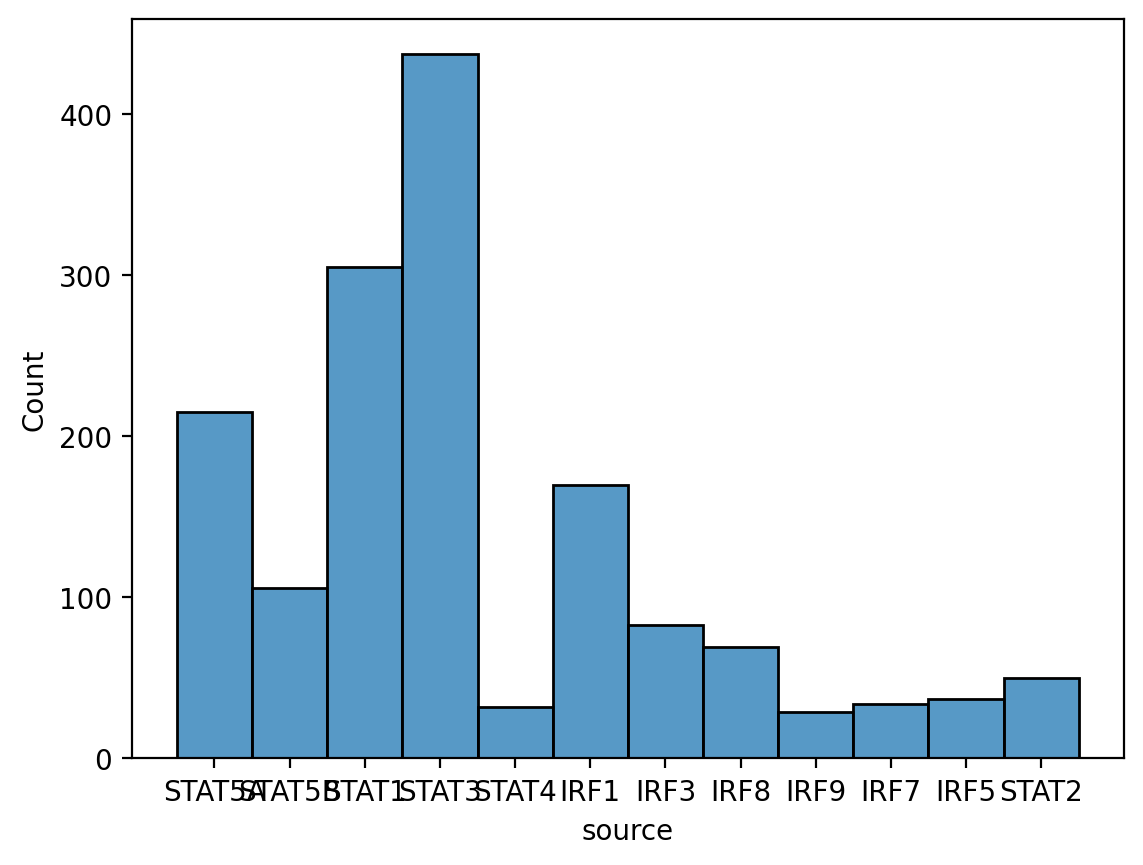

In [30]:
#removeNFKB
tf_int=["IRF3" , "IRF7", "INFA","INFB","IRF9", "STAT3", "STAT4", "STAT5A", "STAT5B",  "IRF1", "IRF5","IRF8", "STAT1", "STAT2" ]
tf_updated=tf[tf['source'].isin(tf_int)]
import seaborn as sns
sns.histplot(tf_updated, x=tf_updated.source)

In [31]:
valid_targets = [g for g in tf_updated["target"].to_list() if g in PBMC_train.var_names]
PBMC_train = PBMC_train[:, valid_targets].copy()

/home/yusuf/Projects/PyTorch/.venv/lib64/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [32]:
PBMC_train

AnnData object with n_obs × n_vars = 13515 × 613
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [33]:
# Filter for cells where condition == "stimulation"
pbmc_stimulated = PBMC_train[PBMC_train.obs["condition"] == "stimulated"]
pbmc_stimulatedX = torch.utils.data.DataLoader(pbmc_stimulated.X.toarray(), batch_size=128) #set up the training data in the right format
pbmc_control = PBMC_train[PBMC_train.obs["condition"] == "control"]
pbmc_controlX = torch.utils.data.DataLoader(pbmc_control.X.toarray(), batch_size=128) #set up the training data in the right format
latent_dims = 50 #choose the number of latent variables


In [34]:
tf_updated

,source,target,weight,resources,references,sign_decision
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
5,STAT5B,IL2,1.0,ExTRI,10022878,regulon
15,STAT1,CDKN1A,1.0,ExTRI;TFactS;TRRUST,10023678;10866323;11162600;12239594;16449678;2...,PMID
16,STAT3,CDKN1A,1.0,ExTRI;NTNU.Curated;TRRUST,10023678;11114718;11773079;12438313;15063116;1...,PMID
42,STAT4,IL12B,1.0,ExTRI,10037767;12893768,default activation
...,...,...,...,...,...,...
41490,IRF1,hsa-miR-342,1.0,ExTRI,19151778,default activation
41491,IRF9,hsa-miR-342,1.0,ExTRI,19151778,default activation
41503,STAT1,hsa-miR-221-3p,1.0,ExTRI,20110463,default activation
41506,STAT3,hsa-miR-21,1.0,ExTRI,20813833;21685938;22210182;23416424,regulon


In [35]:
####### In the following sections, we used and adapted code from https://github.com/LucasESBS/vega ######


In [36]:
# define VEGA's decoder

class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (sparse, one-layer, linear, positive)
  """
  def __init__(self,
               mask):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) # we define the architecture of the decoder below with the class "SparseLayer"

  def forward(self, x):
    z = self.sparse_layer(x.to(device))
    return(z)

  def weights(self):
      """
      obtain all weights
      """
      w = self.sparse_layer[0].weight
      return w


# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))
        self.reset_parameters()

        # mask weight
        self.weight.data = self.weight.data * self.mask

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)


######### You don't need to understand this part of the code in detail #########
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):

        weight = weight * mask # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask


In [37]:
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [38]:
#training loop
def trainVEGA(vae, data, epochs=10, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    vae.train() #train mode
    losses = []
    klds = []
    mses = []

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()
            vae.decoder.weights() # we restrict the decoder for positive weights

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [39]:
#vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, z_dropout = 0.5, dropout = 0.3).to(device)
# model training
#vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, pbmc_stimulatedX,epochs = 100, beta = 0.0001) #takes about 2 mins on GPU
# plot the loss curve
#plt.plot(vega_losses)
#plt.plot(vega_klds)
#plt.plot(vega_mses)

In [40]:
def Dataframecombined_2(pbmc, trans, rep, nome):
    pbmc, mask = create_mask(pbmc, trans, add_nodes=1)
    print("mask done")
    # Estrai nome condizione (modifica se la chiave è diversa)
    cond_name = nome

    # Crea DataLoader
    pbmcX = torch.utils.data.DataLoader(pbmc.X.toarray(), batch_size=128)

    # DataFrame finale
    dfs = pd.DataFrame(columns=['iteration', 'tf', 'gene', 'wei', 'cond'])

    for i in range(rep):
        if i % 2 == 0:
            print(f"Iteration: {i}")

        # Inizializza e addestra VEGA
        vega = VEGA(
            latent_dims=mask.shape[1],
            input_dims=mask.shape[0],
            mask=mask.T,
            z_dropout=0.5,
            dropout=0.3
        ).to(device)

        vega, _, _, _ = trainVEGA(vega, pbmcX, epochs=100, beta=0.001)
        pbmc.obsm["latent_embedding"] = to_latent(vega, pbmc) # project the cells to the model's latent space

# UMAP based on the latent embedding
        sc.pp.neighbors(pbmc, use_rep='latent_embedding', n_neighbors=15)

        sc.tl.umap(pbmc, random_state=1) #set random state to ensure reproducibility

        sc.pl.umap(pbmc, color=["cell_type"], size=10, ncols = 1)
        sc.pl.umap(pbmc, color=["condition"], size=10, ncols = 1)
        # Ottieni pesi
        weights = vega.decoder.weights().detach().cpu().numpy()

        # Assumi che tf_names e gmv_names siano disponibili
        tf_names = pbmc.uns["_vega"]["gmv_names"]
        gene_names = pbmc_stimulated.var_names

        # Verifica le dimensioni
        assert len(gene_names) == weights.shape[0], "Mismatch tra numero geni e righe dei pesi"
        assert len(tf_names) == weights.shape[1], "Mismatch tra numero TF e colonne dei pesi"

        # Costruzione delle righe
        rows = [
            {
                'iteration': i,
                'tf': tf_names[tf_idx],
                'gene': gene_names[gene_idx],
                'wei': weights[gene_idx][tf_idx],
                'cond': cond_name
            }
            for gene_idx in range(len(gene_names))
            for tf_idx in range(len(tf_names))
        ]

        df = pd.DataFrame(rows)
        dfs = pd.concat([dfs, df], ignore_index=True)

    return dfs


In [41]:
def create_mask(adata, transcription, add_nodes:int=1, sep = "\t"):
    """
    Initialize mask M for GMVs from a .gmt file
    Args:
        adata (Anndata): Scanpy single-cell object, we will store the computed mask and the names of the biological processes there
        gmt_path (str): path to .gmt file
        add_nodes (int): Additional latent nodes for capturing additional variance
    Return:
        adata (Anndata): Scanpy single-cell object that now stores the computed mask and the names of biological processes (in the .uns["_vega"] attribute)
        mask (array): mask M that specifies whether a gene is included in the gene set of a pathway (value one) or not (value zero)
    """

    gmv_dict={}
    for x in set(transcription.source):
      gmv_dict[x]=transcription.loc[transcription.source==x].target.to_list()

    feature_list = adata.var.index.tolist()

    # Create mask
    mask = np.zeros((len(feature_list), len(gmv_dict)))
    for j, k in enumerate(gmv_dict.keys()):
        for i in range(mask.shape[0]):
            if feature_list[i] in gmv_dict[k]:
                mask[i,j] = 1

    # Add unannotated nodes
    vec = np.ones((mask.shape[0], add_nodes))
    mask = np.hstack((mask, vec))

    adata.uns['_vega'] = {} #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = mask
    adata.uns['_vega']['gmv_names'] = list(gmv_dict.keys()) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]

    return adata, mask

In [42]:
pbmc_stimulated, mask_s = create_mask(pbmc_stimulated, tf_updated, add_nodes=1)
pbmc_stimulated.uns["_vega"]["gmv_names"]
pbmc_control, mask_c = create_mask(pbmc_control, tf_updated, add_nodes=1)
pbmc_control.uns["_vega"]["gmv_names"]

/tmp/ipykernel_8671/667081440.py:30: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['_vega'] = {} #create attribute "_vega" to store the mask and pathway information
/home/yusuf/Projects/PyTorch/.venv/lib64/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


['IRF1',
 'STAT1',
 'STAT5B',
 'STAT4',
 'STAT5A',
 'IRF3',
 'IRF9',
 'IRF7',
 'STAT2',
 'STAT3',
 'IRF8',
 'IRF5',
 'UNANNOTATED_0']

In [43]:
pbmc_1, mask = create_mask(pbmc_stimulated, tf_updated, add_nodes=1)
pbmcX = torch.utils.data.DataLoader(pbmc_1.X.toarray(), batch_size=128)

vega = VEGA(
            latent_dims=mask.shape[1],
            input_dims=mask.shape[0],
            mask=mask.T,
            z_dropout=0.5,
            dropout=0.3
        ).to(device)

        # Addestramento
vega, vega_losses, vega_klds, vega_mses = trainVEGA(
            vega, pbmcX, epochs=100, beta=0.0001
        )

weights = vega.decoder.weights().detach().cpu().numpy()


epoch:  0  loss:  295.56375
epoch:  1  loss:  246.36978
epoch:  2  loss:  194.43175
epoch:  3  loss:  150.63501
epoch:  4  loss:  127.556206
epoch:  5  loss:  115.83897
epoch:  6  loss:  109.43718
epoch:  7  loss:  103.009636
epoch:  8  loss:  100.80211
epoch:  9  loss:  99.96603
epoch:  10  loss:  93.2906
epoch:  11  loss:  93.43123
epoch:  12  loss:  91.23893
epoch:  13  loss:  89.58714
epoch:  14  loss:  89.03288
epoch:  15  loss:  87.94489
epoch:  16  loss:  88.70658
epoch:  17  loss:  90.43905
epoch:  18  loss:  85.598564
epoch:  19  loss:  85.52425
epoch:  20  loss:  83.72764
epoch:  21  loss:  82.86192
epoch:  22  loss:  86.0417
epoch:  23  loss:  92.13537
epoch:  24  loss:  83.451065
epoch:  25  loss:  80.15729
epoch:  26  loss:  80.652565
epoch:  27  loss:  79.95481
epoch:  28  loss:  79.07786
epoch:  29  loss:  78.30365
epoch:  30  loss:  77.425606
epoch:  31  loss:  76.84101
epoch:  32  loss:  77.8938
epoch:  33  loss:  77.78254
epoch:  34  loss:  76.06866
epoch:  35  loss: 

In [44]:
weights = vega.decoder.weights().detach().cpu().numpy()
tf_names = pbmc.uns["_vega"]["gmv_names"]
gene_names = pbmc_stimulated.var_names
weights[10]

NameError: name 'pbmc' is not defined

In [ ]:
def Dataframecombined(pbmc,trans, rep):

  pbmc, mask = create_mask(pbmc, trans, add_nodes=1)
  pbmc.uns["_vega"]["gmv_names"]
  pbmcX=torch.utils.data.DataLoader(pbmc.X.toarray(), batch_size=128)
  dfs = []
  for i in range(rep):
    if i%2==0:
      print(i)
    vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, z_dropout = 0.3, dropout = 0.3).to(device)
    # model training
    vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, pbmcX,epochs = 100, beta = 0.0001)
    df = pd.DataFrame(vega.decoder.weights().detach().cpu().numpy())
    dfs.append(df)
  combined_df = pd.DataFrame(index=dfs[0].index, columns=dfs[0].columns)

  for row in combined_df.index:
    for col in combined_df.columns:
      combined_df.at[row, col] = [df.at[row, col] for df in dfs]
  combined_df.columns=pbmc.uns["_vega"]["gmv_names"]
  combined_df.index=pbmc.var_names
  return(combined_df)




In [ ]:

results_yusuf=Dataframecombined_2(PBMC_train, tf_updated,1,"nome")

mask done
Iteration: 0
epoch:  0  loss:  199.72127
epoch:  1  loss:  138.9852
epoch:  2  loss:  103.78036
epoch:  3  loss:  89.241165
epoch:  4  loss:  83.81352
epoch:  5  loss:  80.75987
epoch:  6  loss:  79.22928
epoch:  7  loss:  75.20092
epoch:  8  loss:  74.180916
epoch:  9  loss:  73.76062
epoch:  10  loss:  73.86408
epoch:  11  loss:  71.3106
epoch:  12  loss:  71.16206
epoch:  13  loss:  71.378426
epoch:  14  loss:  70.93829
epoch:  15  loss:  70.78038
epoch:  16  loss:  69.83668
epoch:  17  loss:  70.01413
epoch:  18  loss:  70.5858
epoch:  19  loss:  70.5614
epoch:  20  loss:  71.00767
epoch:  21  loss:  69.88421
epoch:  22  loss:  69.81125
epoch:  23  loss:  69.87921
epoch:  24  loss:  69.07558
epoch:  25  loss:  68.5666
epoch:  26  loss:  68.977974
epoch:  27  loss:  69.3379
epoch:  28  loss:  68.19474
epoch:  29  loss:  69.1788
epoch:  30  loss:  68.73277
epoch:  31  loss:  70.25398
epoch:  32  loss:  69.906876
epoch:  33  loss:  68.45035
epoch:  34  loss:  69.81926
epoch:

ValueError: Input contains NaN.

In [ ]:
PBMC_train.obsm["latent_embedding"] = to_latent(vega, PBMC_train) # project the cells to the model's latent space

# UMAP based on the latent embedding
sc.pp.neighbors(pbmc_stimulated, use_rep='latent_embedding', n_neighbors=15)
sc.tl.umap(pbmc_stimulated, random_state=1) #set random state to ensure reproducibility
sc.pl.umap(pbmc_stimulated, color=["cell_type", "condition"], size=10, ncols = 1)

,iteration,tf,gene,wei,cond


In [ ]:
import pandas as pd
combined_df_c=Dataframecombined_2(pbmc_control, tf_updated,3, "control")


Iteration: 0
epoch:  0  loss:  616.9858
epoch:  1  loss:  488.65372
epoch:  2  loss:  409.5608
epoch:  3  loss:  358.43567
epoch:  4  loss:  320.52173
epoch:  5  loss:  286.83154
epoch:  6  loss:  269.2058
epoch:  7  loss:  261.2426
epoch:  8  loss:  252.14278
epoch:  9  loss:  250.11417
epoch:  10  loss:  247.25433
epoch:  11  loss:  245.95013
epoch:  12  loss:  241.74161
epoch:  13  loss:  241.49963
epoch:  14  loss:  239.777
epoch:  15  loss:  238.08429
epoch:  16  loss:  236.76042
epoch:  17  loss:  235.75078
epoch:  18  loss:  233.77855
epoch:  19  loss:  232.25452
epoch:  20  loss:  230.1718
epoch:  21  loss:  229.23192
epoch:  22  loss:  228.132
epoch:  23  loss:  227.81432
epoch:  24  loss:  226.68024
epoch:  25  loss:  224.43901
epoch:  26  loss:  222.99278
epoch:  27  loss:  222.7928
epoch:  28  loss:  221.10545
epoch:  29  loss:  219.87788
epoch:  30  loss:  220.01022
epoch:  31  loss:  218.27345
epoch:  32  loss:  218.33176
epoch:  33  loss:  216.74449
epoch:  34  loss:  21

<ipython-input-103-17cae28a0475>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat([dfs, df], ignore_index=True)


epoch:  0  loss:  614.15576
epoch:  1  loss:  489.55127
epoch:  2  loss:  406.5596
epoch:  3  loss:  355.50757
epoch:  4  loss:  320.1222
epoch:  5  loss:  288.4618
epoch:  6  loss:  265.3715
epoch:  7  loss:  256.0473
epoch:  8  loss:  250.37758
epoch:  9  loss:  248.75801
epoch:  10  loss:  246.07164
epoch:  11  loss:  243.14182
epoch:  12  loss:  241.4267
epoch:  13  loss:  238.27081
epoch:  14  loss:  236.30449
epoch:  15  loss:  236.41663
epoch:  16  loss:  234.07443
epoch:  17  loss:  232.63957
epoch:  18  loss:  231.85664
epoch:  19  loss:  230.79715
epoch:  20  loss:  228.82309
epoch:  21  loss:  227.02882
epoch:  22  loss:  226.01804
epoch:  23  loss:  225.27406
epoch:  24  loss:  224.0225
epoch:  25  loss:  222.26237
epoch:  26  loss:  221.35918
epoch:  27  loss:  220.38895
epoch:  28  loss:  219.08437
epoch:  29  loss:  218.74503
epoch:  30  loss:  217.79846
epoch:  31  loss:  216.16446
epoch:  32  loss:  215.73634
epoch:  33  loss:  215.05461
epoch:  34  loss:  213.81258
ep

In [ ]:
combined_df_s=Dataframecombined_2(pbmc_stimulated,tf_updated, 3, "stimulated")

Iteration: 0
epoch:  0  loss:  652.983
epoch:  1  loss:  505.90082
epoch:  2  loss:  416.48615
epoch:  3  loss:  358.7676
epoch:  4  loss:  324.7546
epoch:  5  loss:  293.73373
epoch:  6  loss:  271.16193
epoch:  7  loss:  262.98734
epoch:  8  loss:  258.48026
epoch:  9  loss:  255.44656
epoch:  10  loss:  253.86113
epoch:  11  loss:  252.04564
epoch:  12  loss:  249.16663
epoch:  13  loss:  248.18228
epoch:  14  loss:  246.81584
epoch:  15  loss:  245.04796
epoch:  16  loss:  243.2638
epoch:  17  loss:  241.56734
epoch:  18  loss:  240.90605
epoch:  19  loss:  239.12535
epoch:  20  loss:  237.65388
epoch:  21  loss:  235.42233
epoch:  22  loss:  234.165
epoch:  23  loss:  233.11096
epoch:  24  loss:  232.10336
epoch:  25  loss:  230.82803
epoch:  26  loss:  229.77214
epoch:  27  loss:  227.98512
epoch:  28  loss:  227.39774
epoch:  29  loss:  226.2761
epoch:  30  loss:  225.05424
epoch:  31  loss:  223.79478
epoch:  32  loss:  223.54015
epoch:  33  loss:  221.59055
epoch:  34  loss:  

<ipython-input-103-17cae28a0475>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat([dfs, df], ignore_index=True)


epoch:  0  loss:  648.7758
epoch:  1  loss:  508.53857
epoch:  2  loss:  418.23502
epoch:  3  loss:  362.0272
epoch:  4  loss:  316.88406
epoch:  5  loss:  288.68378
epoch:  6  loss:  279.38043
epoch:  7  loss:  269.42194
epoch:  8  loss:  263.31613
epoch:  9  loss:  259.72473
epoch:  10  loss:  256.3785
epoch:  11  loss:  254.59338
epoch:  12  loss:  251.91287
epoch:  13  loss:  249.70596
epoch:  14  loss:  248.63268
epoch:  15  loss:  246.13817
epoch:  16  loss:  244.55547
epoch:  17  loss:  243.14272
epoch:  18  loss:  241.94713
epoch:  19  loss:  241.55266
epoch:  20  loss:  238.43993
epoch:  21  loss:  236.9591
epoch:  22  loss:  235.81702
epoch:  23  loss:  234.12874
epoch:  24  loss:  233.06999
epoch:  25  loss:  232.18208
epoch:  26  loss:  231.42
epoch:  27  loss:  230.17043
epoch:  28  loss:  229.32312
epoch:  29  loss:  227.53072
epoch:  30  loss:  225.92746
epoch:  31  loss:  224.69894
epoch:  32  loss:  223.3064
epoch:  33  loss:  221.96901
epoch:  34  loss:  221.38612
epo

In [ ]:
union=pd.concat([combined_df_c,combined_df_s])

In [ ]:
union

,iteration,tf,gene,wei,cond
0,0,IRF1,AL627309.1,-0.00000,control
1,0,IRF9,AL627309.1,-0.00000,control
2,0,STAT5B,AL627309.1,-0.00000,control
3,0,IRF3,AL627309.1,-0.00000,control
4,0,IRF7,AL627309.1,0.00000,control
...,...,...,...,...,...
272917,2,STAT3,S100B,0.00000,stimulated
272918,2,STAT5A,S100B,0.00000,stimulated
272919,2,STAT2,S100B,-0.00000,stimulated
272920,2,STAT1,S100B,0.00000,stimulated


<Axes: xlabel='tf', ylabel='wei'>

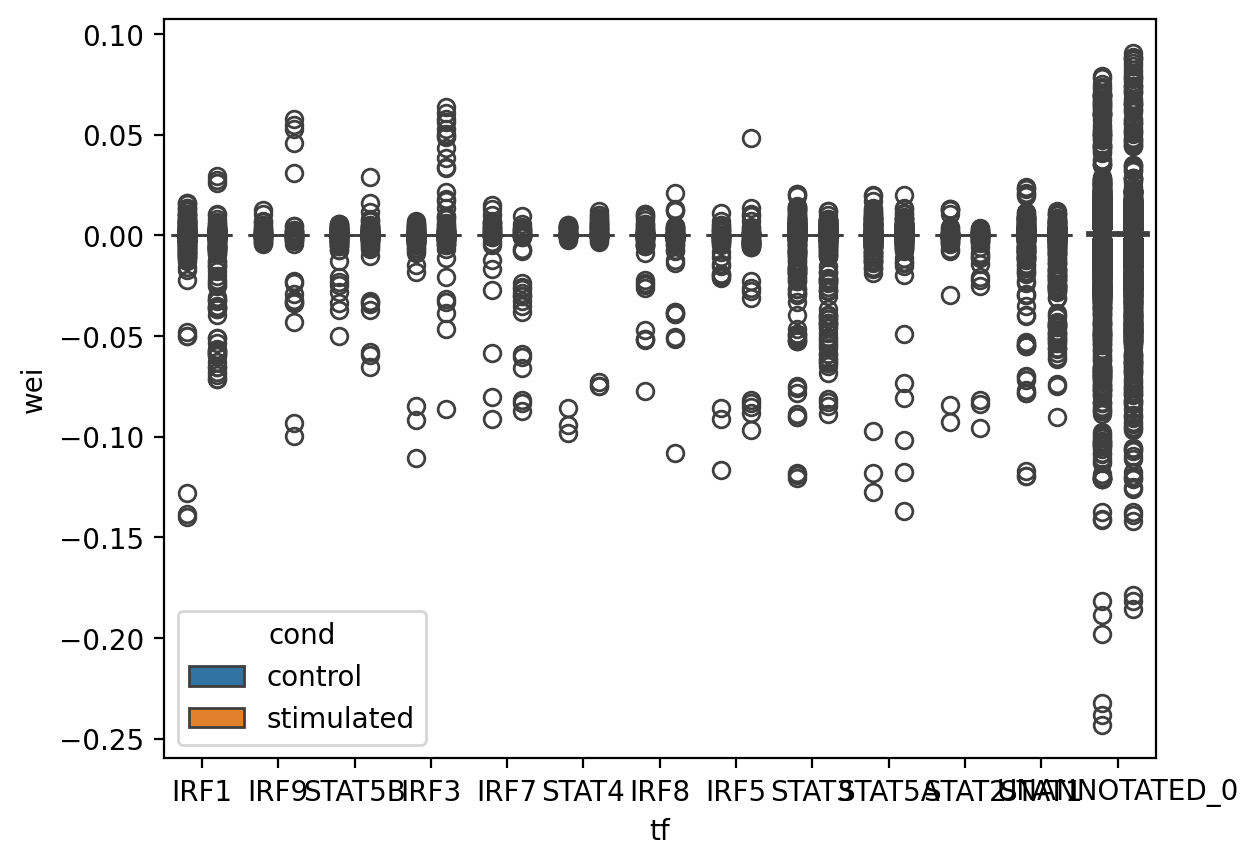

In [ ]:
import seaborn as sns
sns.boxplot(union, x="tf", y="wei",  hue="cond")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che combined_df_c e combined_df_s abbiano la stessa struttura (uguali colonne e indici)
for col in combined_df_c.columns:
# Seleziona i top 9 geni con la maggiore variazione (simile a prima)
  diff = [(max(combined_df_c[col][i]) - min(combined_df_c[col][i]) + max(combined_df_s[col][i]) - min(combined_df_s[col][i])) / 2
        for i in range(len(combined_df_c))
    ]
    # Seleziona i geni con variazione maggiore (escludendo il primo)
  indicimax = sorted(range(len(diff)), key=lambda i: diff[i], reverse=True)[1:10]



# Creazione di un DataFrame lungo con i dati da combined_df_c e combined_df_s
data_long = []

# Itera per i geni selezionati
for i in indicimax:
    gene_name = combined_df_c.index[i]  # Nome del gene

    # Aggiungi i valori per combined_df_c, esplodendo la lista
    for val in combined_df_c.iloc[i]:
        data_long.append({"gene": gene_name, "value": val, "source": "combined_df_c"})

    # Aggiungi i valori per combined_df_s, esplodendo la lista
    for val in combined_df_s.iloc[i]:
        data_long.append({"gene": gene_name, "value": val, "source": "combined_df_s"})

# Convertiamo la lista in un DataFrame
df_long = pd.DataFrame(data_long)
# "Esplodi" le liste di valori in righe separate
df_long_exploded = df_long.explode('value')

print(df_long_exploded)
# Ora creiamo il boxplot con Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long_exploded, x="gene", y="value", hue="source", palette={"combined_df_c": "lightblue", "combined_df_s": "lightgreen"})

# Imposta il titolo e ruota le etichette per l'asse X
plt.title("Confronto boxplot tra combined_df_c e combined_df_s")
plt.xticks(rotation=90)  # Ruota le etichette dell'asse X (nomi dei geni)
plt.tight_layout()
plt.show()


In [ ]:
combined_df_c


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for col in combined_df_c.columns:
    # Calcola la variazione per ogni gene su df1
    diff = [max(combined_df_c[col][i]) - min(combined_df_c[col][i])
    ]
    print(diff)
    # Seleziona i geni con variazione maggiore (escludendo il primo)

    indicimax = sorted(range(len(diff)), key=lambda i: diff[i], reverse=True)[1:10]
    print(indicimax)
    # Prepara i valori per il boxplot
    box_data = []
    box_labels = []
        # Colori per i due DataFrame
    color1 = 'lightblue'  # Colore per df1
    color2 = 'lightgreen'  # Colore per df2


    for i in indicimax:
        gene_name = combined_df_c.index[i]
        vals1 = combined_df_c[col][i]  # lista di 5 valori dal primo df
        vals2 = combined_df_s[col][i]  # lista di 5 valori dal secondo df


        # Aggiungi i dati per df1 e df2
        box_data.append(vals1)
        box_data.append(vals2)
        # Aggiungi solo una etichetta per ogni gene, ma le etichette saranno duplicate (una per df1 e una per df2)
        box_labels.append(gene_name)  # Etichetta per df1
        box_labels.append('')
    # Creazione del boxplot
    plt.figure(figsize=(12, 6))
    box = plt.boxplot(box_data, labels=box_labels, patch_artist=True, vert=True)

    # Imposta il colore dei box (alternato per df1 e df2)
    for i, patch in enumerate(box['boxes']):
        if i % 2 == 0:
            patch.set_facecolor(color1)  # Colore per df1
        else:
            patch.set_facecolor(color2)  # Colore per df2

    plt.title(f"Confronto boxplot per TF {col}")
    plt.xticks(rotation=90)  # Rotazione etichette per una migliore leggibilità
    plt.tight_layout()
    plt.show()

In [ ]:
for col in combined_df.columns:
    diff=[max(pos)-min(pos) for pos in combined_df[col]]
    indicimax=sorted(range(len(diff)), key=lambda i: diff[i], reverse=True)[1:10]
    selected_values = [combined_df[col][i] for i in indicimax]
    row_names = [combined_df.index[i] for i in indicimax]

    plt.boxplot(selected_values, labels=row_names, vert=True)
    plt.title(f"Boxplot per tf {col}")
    #plt.show()



In [ ]:
for p_idx, pathway in enumerate(pathway_names):
    # Raccogli i pesi per ogni gene nei 5 esperimenti
    gene_weights = []
    for g_idx in range(len(gene_names)):
        values = [weight_tot[exp][g_idx][p_idx] for exp in range(len(weight_tot))]
        gene_weights.append(values)  # Lista di 5 valori (uno per esperimento) per ogni gene
    print(gene_weights)
    # Crea il boxplot
#    plt.figure(figsize=(10, 5))
#    plt.boxplot(gene_weights, labels=gene_names, showfliers=False)
#    plt.title(f'Boxplot dei pesi per pathway: {pathway}')
#    plt.ylabel('Peso')
#    plt.xticks(rotation=90)
#    plt.grid(axis='y')
#    plt.tight_layout()
#    plt.show()


In [ ]:
for x,y in enumerate(weight_tot):
  print(x,y)

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

pathway_names = pbmc_stimulated.uns["_vega"]["gmv_names"]
gene_names = pbmc_stimulated.var_names


for x in range(8):
  weight_tf1=pd.DataFrame(weight_tot[1][1][x], columns=pathway_names, index=gene_names)
  weight_tf1[pathway_names[x]].plot(kind='line', figsize=(8, 4), title=2)
  plt.gca().spines[['top', 'right']].set_visible(False)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

weights = vega.decoder.weights().detach().cpu().numpy()

# Get pathway/module names and gene names from the model
pathway_names = pbmc_stimulated.uns["_vega"]["gmv_names"]
gene_names = pbmc_stimulated.var_names

# Create a DataFrame for easier plotting
df = pd.DataFrame(weights, columns=pathway_names, index=gene_names)

# Optional: show only top N genes or pathways for readability
top_pathways = df.index[:20]
top_genes = df.columns[:50]
df_subset = df.loc[top_pathways, top_genes]

# Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(df_subset, cmap="viridis")
plt.title("Decoder Positive Weights")
plt.xlabel("TF")
plt.ylabel("Regulated genes")
plt.tight_layout()
plt.show()

In [ ]:
def to_latent(vae, adata):
        latent = []
        data = torch.tensor(adata.X.toarray()).to(device)
        vae.eval() # we need to set the model to evaluation mode, so that the dropout is no longer considered
        z = vae.encoder(data)
        latent += [z.to("cpu")]
        return torch.cat(latent).detach().numpy()

In [ ]:
pbmc_stimulated.obsm["latent_embedding"] = to_latent(vega, pbmc_stimulated) # project the cells to the model's latent space

# UMAP based on the latent embedding
sc.pp.neighbors(pbmc_stimulated, use_rep='latent_embedding', n_neighbors=15)
sc.tl.umap(pbmc_stimulated, random_state=1) #set random state to ensure reproducibility
sc.pl.umap(pbmc_stimulated, color=["cell_type", "condition"], size=10, ncols = 1)

ValueError: Input X contains NaN.
KNeighborsTransformer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
pbmc_stimulated.uns["_vega"]["gmv_names"]
pbmc_stimulated.uns["_vega"]["gmv_names"]

In [ ]:
zmt = pbmc_stimulated.uns["_vega"]["gmv_names"] # the names of the GMVs are stored here
pw_activities = pbmc_stimulated.obsm["latent_embedding"] # pathway activities (we stored them here when projecting the data to the latent space (see above))
for tf in tf_int:
    # for visualization with the scanpy package, we need to provide the annotation (based on which cells should be colored) in the .obs attribute
    # Use a different key for TF activity in obs to avoid conflict with gene names
    tf_activity_key = f"{tf}_activity"
    pbmc_stimulated.obs[tf_activity_key] = pbmc_stimulated.obsm["latent_embedding"][:, zmt.index(tf)]
    sc.pl.umap(pbmc_stimulated, color=[tf_activity_key], size=10, ncols=1)